In [ ]:
import os, glob
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import logging
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)

In [ ]:
# data_type = ['unknown_data', 'test_graph', 'test_essay']
data_type = 'unknown_data'

# method = ['td-idf', 'bm25', 'dm', 'dbow']
method = 'tf-idf'

## If data_type = 'unknown_data', that is, we want to annotate new (unlabeled) essays:

In [3]:
#  filename : data
realec_data = {}
folder = "REALEC_clean/exam/Exam2018"

print()
for file in glob.glob(folder + "/*_2.txt"):
    with open(file) as f:
        realec_data[file] = f.read()

## If we want to see the algorithms on the labeled data of 2017:

Separate opinion essays (marked_essay) and description of graphs (marked_graph)

In [4]:
marked_graph = pd.read_csv("REALEC_clean/exam/2017marked_graph.csv")

In [5]:
marked_essay = pd.read_csv("REALEC_clean/exam/2017marked_essay.csv")

Text preprocessing function and BM25:

In [6]:
def normalize(s, sw=False):
    res = word_tokenize(s)

    nltk_lem = WordNetLemmatizer()
    res = [nltk_lem.lemmatize(i) for i in res]
    res = [s.lower() for s in res]
    res = [i for i in res if i not in stopwords.words('english')]
    res = [s for s in res if s not in string.punctuation]
    #res = [s for s in res if not s.isdigit()]

    return res


class BM25(object):
    def __init__(self, b=0.75, k1=1.6):
        self.vectorizer = TfidfVectorizer(norm=None, smooth_idf=False)
        self.b = b
        self.k1 = k1

    def fit(self, X):
        """ Fit IDF to documents X """
        self.vectorizer.fit(X)
        y = super(TfidfVectorizer, self.vectorizer).transform(X)
        self.avdl = y.sum(1).mean()

    def transform(self, q, X):
        """ Calculate BM25 between query q and documents X """
        b, k1, avdl = self.b, self.k1, self.avdl

        # apply CountVectorizer
        X = super(TfidfVectorizer, self.vectorizer).transform(X)
        len_X = X.sum(1).A1
        q, = super(TfidfVectorizer, self.vectorizer).transform([q])
        assert sparse.isspmatrix_csr(q)

        # convert to csc for better column slicing
        X = X.tocsc()[:, q.indices]
        denom = X + (k1 * (1 - b + b * len_X / avdl))[:, None]
        # idf(t) = log [ n / df(t) ] + 1 in sklearn, so it need to be coneverted
        # to idf(t) = log [ n / df(t) ] with minus 1
        idf = self.vectorizer._tfidf.idf_[None, q.indices] - 1.
        numer = X.multiply(np.broadcast_to(idf, X.shape)) * (k1 + 1)                                                          
        return (numer / denom).sum(1).A1

In [7]:
data = pd.DataFrame()

names = []
texts = []
source = []
true_labels = []

if data_type == "unknown_data":
    for k, v in tqdm(realec_data.items()):
        names.append(k.split("/")[-1])
        texts.append(" ".join(normalize(v)))
        source.append(v)
elif data_type == "test_graph":
    for v in tqdm(marked_graph.values):
        if type(v[4]) == float:
            continue
        if len(v[4]) == 0:
            continue
        names.append(v[4])
        texts.append(" ".join(normalize(v[4])))
        true_labels.append(int(v[3][1]))
        source.append(v[4])
    data['true_labels'] = true_labels
elif data_type == "test_essay":
    for v in tqdm(marked_essay.values):
        if type(v[4]) == float:
            continue
        if len(v[4]) == 0:
            continue
        names.append(v[1])
        texts.append(" ".join(normalize(v[4])))
        true_labels.append(int(v[3][1]))
        source.append(v[4])
        
    data['true_labels'] = true_labels
        
data['name'] = names
data['text'] = texts
data['source_text'] = source

100%|██████████| 299/299 [00:21<00:00, 14.13it/s]


In [8]:
len(data)

299

## Obtain vector representations by the corresponding algorithm:

In [9]:
# 'tf-idf', 'bm25, 'dm', 'dbow'

method = 'tf-idf'
df = []

if method == 'tf-idf':
    vectorizer = TfidfVectorizer(max_features=5000)
    df = vectorizer.fit_transform(data.text.values)
    df = df.toarray()
elif method == 'bm25':
    bm25 = BM25()
    bm25.fit(data.text.values)
    for i in tqdm(data.text.values):
        df.append(bm25.transform(i, data.text.values))
    df = np.array(df)
    df = df.toarray()
else:
    documents = []
    for i, doc in tqdm(enumerate(data.values)):
        documents.append(TaggedDocument(doc, [i]))
    
    max_epochs = 10
    vec_size = 100
    window = 2
    min_count = 1
    
    if method == 'dm':
        set_dm_alg=1
    elif method == 'dbow':
        set_dm_alg=0
        max_epochs = 10
        vec_size = 100
        window = 2
        min_count = 1
    else:
        print('error: ' + method)
        
    model = Doc2Vec(documents, vector_size=vector_size, window=window,
                    min_count=min_count, workers=12, epochs=max_epochs, dm=set_dm_alg)
    for i in range(len(model.docvecs)):
        df.append(model.docvecs[i])
    df = np.array(df)

### If we want to choose doc2vec parameters, we start optuna with the necessary ranges:

In [39]:
# import optuna


# documents = []
# for i, doc in tqdm(enumerate(data.values)):
#     documents.append(TaggedDocument(doc, [i]))
        

# def objective(trial):
#     vector_size = trial.suggest_int('vector_size', 10, 200)
#     window = trial.suggest_int('window', 1, 15)
#     min_count = trial.suggest_int('min_count', 1, 10)
#     epochs = trial.suggest_int('epochs', 2, 50)
#     model = Doc2Vec(documents, vector_size=vector_size, window=window,
#                     min_count=min_count, workers=12, epochs=epochs, dm=1)
#     df = []
#     for i in range(len(model.docvecs)):
#         df.append(model.docvecs[i])

#     df = np.array(df)
#     model_local = KMeans(n_clusters=9).fit(df)
#     pred = model_local.predict(df)
#     return 1- adjusted_mutual_info_score(pred, data.true_labels.values)
#     #return (x - 2) ** 2

# study = optuna.create_study()
# study.optimize(objective, n_trials=20)

# study.best_params

## let’s look at the averaged values (5 iterations by default) of internal measures on the result of the k-means algorithm with a given number of clusters (by default, the range is from 2 to 15)

max silh_m: 0.08595067994997807
min davi_m: 3.054334656869268


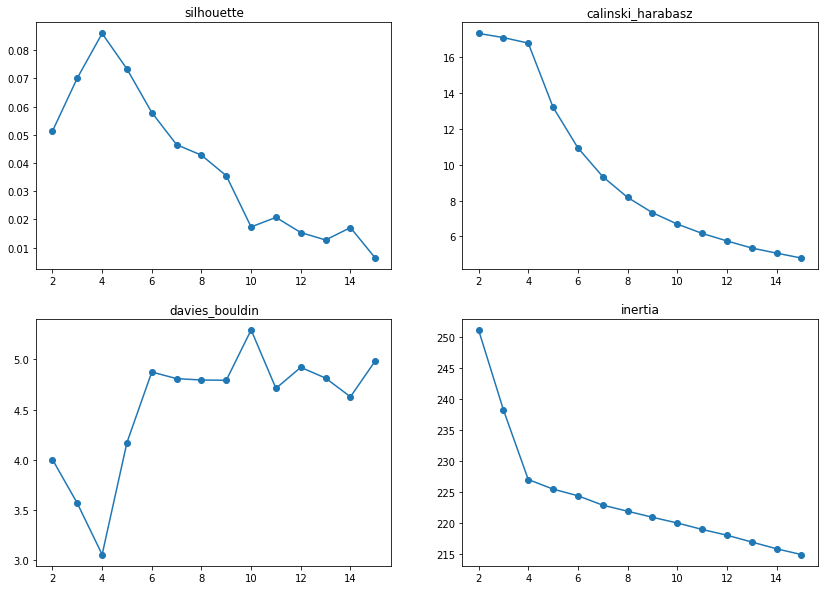

In [11]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score


def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 1)
    
    silh_m = []
    cali_m = []
    davi_m = []
    iner_m = []

    for i in range(4):
        silh = []
        cali = []
        davi = []
        iner = []
        for k in iters:
            model_local = KMeans(n_clusters=k).fit(data)
            pred = model_local.predict(data)
            silh.append(silhouette_score(data, pred))
            cali.append(calinski_harabasz_score(data, pred))
            davi.append(davies_bouldin_score(data, pred))
            iner.append(KMeans(n_clusters=k).fit(data).inertia_)
    #         sse.append(.inertia_)
            print('Fit {} clusters'.format(k), end='\r')
        silh_m.append(silh)
        cali_m.append(cali)
        davi_m.append(davi)
        iner_m.append(iner)
    silh_m = np.array(silh_m).mean(axis=0)
    cali_m = np.array(cali_m).mean(axis=0)
    davi_m = np.array(davi_m).mean(axis=0)
    iner_m = np.array(iner_m).mean(axis=0)
    #f, ax = plt.subplots(1, 1, figsize=(8, 6))
    f, ax = plt.subplots(2, 2, figsize=(14, 10))
    print("max silh_m: " + str(max(silh_m)))
    print("min davi_m: " + str(min(davi_m)))
    
    ax[0, 0].plot(iters, silh_m, marker='o', label='silhouette')
    ax[0, 0].set_title("silhouette")
    ax[0, 1].plot(iters, cali_m, marker='o', label='calinski_harabasz')
    ax[0, 1].set_title("calinski_harabasz")
    ax[1, 0].plot(iters, davi_m, marker='o', label='davies_bouldin')
    ax[1, 0].set_title("davies_bouldin")
    ax[1, 1].plot(iters, iner_m, marker='o', label='inertia')
    ax[1, 1].set_title("inertia")
#
    
find_optimal_clusters(df, 15)

## We get the k-means prediction with the maximum number of clusters:

In [12]:
best_k = 4

In [13]:
model_kmeans = KMeans(n_clusters=best_k).fit(df)
pred = model_kmeans.predict(df)
data['pred'] = pred

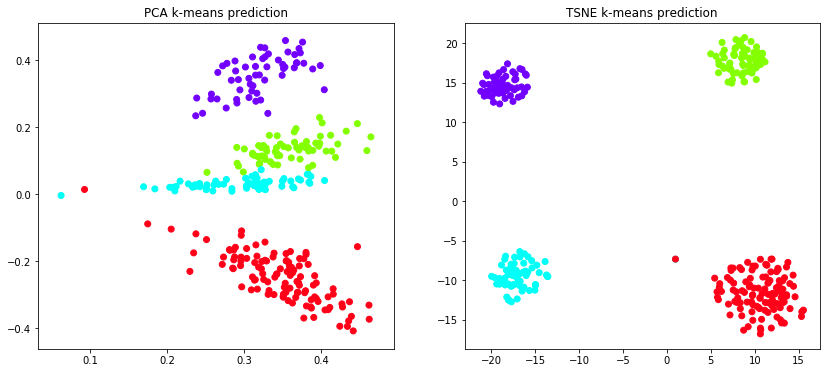

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.pyplot as plt


def plot_tsne_pca(data_df, labels):
    for i in range(len(labels)):
        labels[i] += 1
    max_label = max(labels)
    
    #pca = PCA(n_components=2).fit_transform(data_df)
    pca = TruncatedSVD().fit_transform(data_df)
    #tsne = TSNE().fit_transform(TruncatedSVD(n_components=50).fit_transform(data_df))
    tsne = TSNE().fit_transform(TruncatedSVD(n_components=50).fit_transform(data_df))
    
    idx = np.random.choice(range(pca.shape[0]), size=len(labels), replace=False)
    label_subset = labels
    
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA k-means prediction')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE k-means prediction')
    
plot_tsne_pca(df, pred)

## If there is true labeles, then look at it in the projection:

In [15]:
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import normalized_mutual_info_score

if data_type == 'test_graph' or data_type == 'test_essay':
    print(adjusted_mutual_info_score(pred, data.true_labels.values))
    print(normalized_mutual_info_score(pred, data.true_labels.values))
    plot_tsne_pca(df, data.true_labels.values)

## Hierarchy clustering

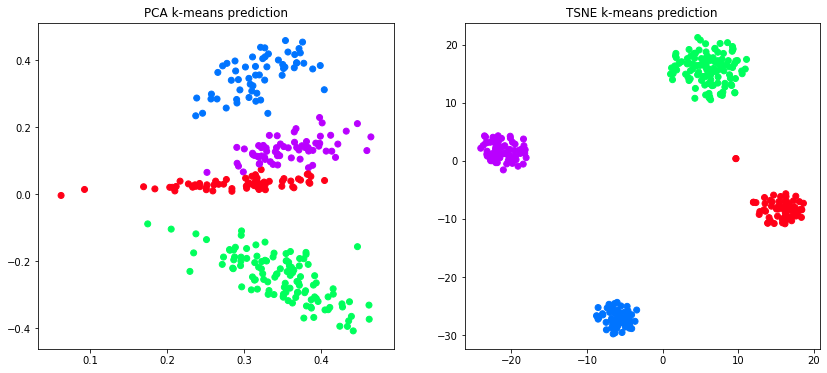

In [16]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc


z = shc.linkage(df, method='ward')
hier_pred = shc.fcluster(z, t=best_k, criterion='maxclust')
plot_tsne_pca(df, hier_pred)


## Spectral clustering

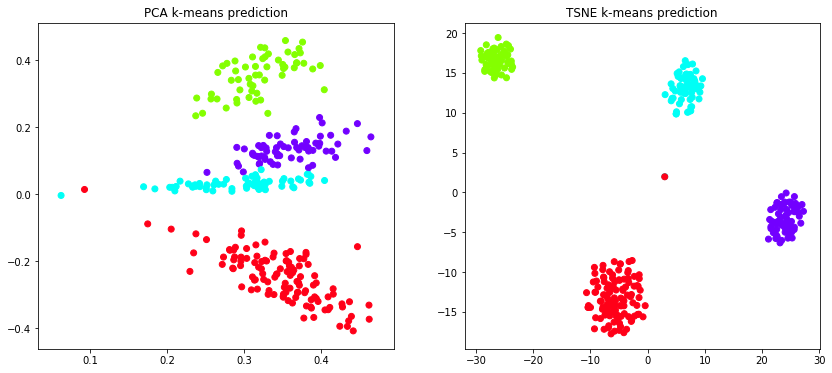

In [17]:
from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(n_clusters=best_k,
        assign_labels="discretize",
        random_state=0).fit(df)
#print(adjusted_mutual_info_score(clustering.labels_, data.true_labels.values))
plot_tsne_pca(df, clustering.labels_)

## DBScan

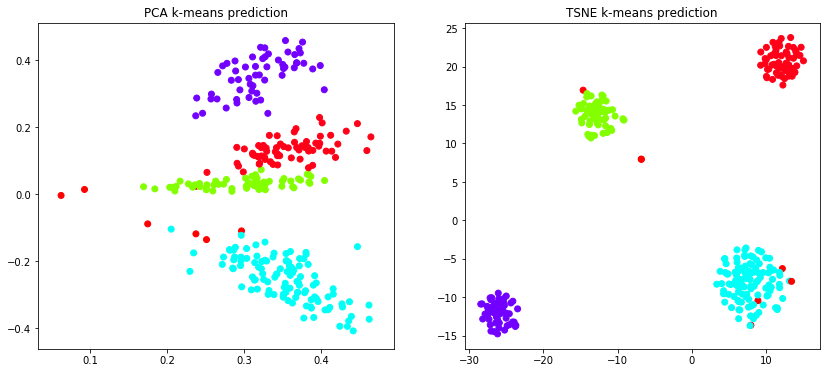

In [18]:
from sklearn.cluster import DBSCAN

dbsc_clustering = DBSCAN(eps=1.25, min_samples=2).fit(df)
#dbsc_clustering.labels_[:100]
plot_tsne_pca(df, dbsc_clustering.labels_)

## Consider the keywords in each cluster:

In [19]:
terms = vectorizer.get_feature_names()

In [20]:
n_max = 30

for i in set(pred):
    buf = []
    for j in range(len(pred)):
        if i == pred[j]:
            buf.append(df[j])
    buf = np.array(buf)
    buf = np.array(buf).sum(axis=0)        
    buf = sorted(zip(buf, terms), key=lambda x: x[0], reverse=True)
    print("Cluster: " + str(i))
    for ind, word in enumerate([i[1] for i in buf][:n_max]):
        print(word, end = "")
        if ind != n_max - 1:
            print(end=", ")
    print("\n")


Cluster: 1
money, time, free, people, work, life, earn, spend, le, prefer, lot, working, person, much, family, thing, leisure, job, friend, earning, hard, want, hand, health, one, without, would, happy, salary, enough

Cluster: 2
country, government, help, people, problem, world, citizen, helping, global, need, one, support, state, issue, nation, focus, war, solve, international, provide, example, others, live, money, situation, life, lot, many, political, point

Cluster: 3
child, family, parent, influence, outside, life, people, friend, home, school, development, factor, role, play, kid, person, different, important, ha, powerful, first, character, teacher, view, one, society, part, member, age, also

Cluster: 4
building, city, architect, beautiful, people, art, purpose, architecture, look, house, important, work, make, beauty, serve, place, like, think, would, one, also, create, live, construction, built, opinion, many, appearance, time, lot



## Let's try to extract keywords using other algorithms, taking as a reference the closest to the center of the cluster text

In [21]:
d = model_kmeans.transform(df)
print(d.shape)
ind_texts = np.argmin(d, axis=0)

(299, 4)


### Consider the result of the RAKE method

In [33]:
import RAKE

rake = RAKE.Rake(stopwords.words('english'))

for i in ind_texts:
    most_val = rake.run(data.source_text.values[i], maxWords=3, minFrequency=2)
    print([j[0] for j in most_val])
    #print(data.source_text.values[i])
    print("\n")

['less free time', 'free time', 'realy like', 'less money', 'people believe', 'people think', 'earn money', 'time', 'earn', 'people', 'money', 'life', 'lot', 'however', 'important', 'spend', 'buy', 'work']


['help', 'country', 'government', 'everyone', 'care']


['important role', 'world', 'child', 'family', 'life', 'children', 'upbringing', 'lot', 'exactly', 'parents', 'behavior', 'mothers', 'opinion', 'things', 'way', 'communication', 'manners']


['look beautiful', 'really important', 'make buildings', 'also', 'buildings', 'make', 'important', 'belive', 'architects', 'people', 'serve', 'purpose', 'works', 'art', 'agree', 'opinion', 'boring', 'artists', 'live', 'think']




#### Consider also the 10 most popular words in each cluster, which RAKE will identify from each essay for each cluster:

In [34]:
import RAKE

rake = RAKE.Rake(stopwords.words('english'))
n_max = 20


for i in sorted(set(pred)):
    d = {}
    for j in range(len(pred)):
        if i == pred[j]:
            for word in rake.run(data.source_text.values[j], maxWords=3, minFrequency=2):
                if word[0] in d.keys():
                    d[word[0]] += 1
                else:
                    d[word[0]] = 1
    print("Cluster: " + str(i))
    counter = 0
    for word, v in {k: v for k, v in sorted(d.items(), key=lambda item: -item[1])}.items():
        if counter >= n_max:
            break
        counter += 1
        print(word, end = "")
        if ind != n_max - 1:
            print(end=", ")
    print("\n")

Cluster: 1
money, people, free time, time, work, life, lot, spend, person, earn, example, family, however, make, friends, prefer, able, want, order, important, 

Cluster: 2
countries, people, help, country, world, government, governments, problems, citizens, lot, live, order, focus, believe, example, money, support, life, planet, need, 

Cluster: 3
child, family, parents, life, children, people, friends, home, influence, development, lot, school, person, outside, view, however, example, way, important, world, 

Cluster: 4
buildings, building, people, art, architects, important, work, purpose, city, live, beauty, architecture, make, lot, think, time, opinion, serve, example, beautiful, 



##  TextRank

In [35]:
from gensim.summarization import keywords as kw

for i in ind_texts:
    most_val = kw(data.text.values[i], pos_filter=[], scores=True)
    print([j[0] for j in most_val])
    #print(data.source_text.values[i])
    print("\n")

['time', 'lot people think money', 'earn', 'earned', 'work', 'got', 'life']


['government', 'country', 'help people', 'lot', 'begin', 'trying', 'try', 'world', 'view', 'politics']


['child', 'people', 'family social', 'life exactly parent', 'world', 'lot', 'want', 'influence', 'behavior manner', 'girl', 'mother', 'thing', 'outside', 'play', 'role', 'crucial', 'way', 'start communicating', 'started communication', 'practise', 'count']


['important building look beautiful', 'think', 'interesting', 'architect', 'colourful', 'colour', 'people belive', 'purpose', 'agree', 'boring']




## Let's also see the library for summarization - summa

In [36]:
from summa import keywords

for i in ind_texts:
    most_val = keywords.keywords(data.text.values[i], scores=True)
    print([j[0] for j in most_val])
    #print(data.source_text.values[i])
    print("\n")
    


2020-05-27 01:30:27,992: INFO: 'pattern' package not found; tag filters are not available for English


['money', 'time', 'lot people', 'earn', 'earned', 'work', 'free', 'got', 'life']


['nowadays lot discussion', 'correct begin large', 'government', 'world essay shown']


['child', 'people', 'family social', 'life exactly parent', 'world', 'lot', 'influence', 'want', 'behavior manner', 'girl', 'mother', 'thing', 'practise', 'outside', 'play', 'role', 'crucial', 'way', 'start communicating', 'started communication', 'count']


['important building look beautiful', 'architect make', 'interesting', 'think', 'colourful', 'colour', 'people belive', 'purpose', 'agree']




## Let us derive the names of the two most distant essays from the corresponding centroids, perhaps these are outliers (for 2018, for example, these are two descriptions of graphs in a variety of opinion essays)

In [37]:

d = model_kmeans.transform(df)
print(d.shape)
ind_texts = np.argmin(d, axis=0)
ind_texts

(299, 4)


array([ 88,  27, 199, 270])

In [38]:
for i in d.argsort(axis=0)[-2:, :].reshape((4, -1)):
    for j in i:
        print(data.name.values[j])
    print()

EEr_117_2.txt
EEr_117_2.txt

EEr_117_2.txt
EEr_177_2.txt

EEr_104_2.txt
EEr_91_2.txt

EEr_104_2.txt
EEr_104_2.txt

